# Roberta with LSTM On Top

Based on: https://github.com/prakashpandey9/Text-Classification-Pytorch


In [0]:
#!pip install transformers

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4
# from google.colab import drive
from sklearn.model_selection import train_test_split

## PyTorch Transformer
from transformers import RobertaModel, RobertaTokenizer

## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch import device as device_
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

1.2.0
True
10.0


## Load Data

In [0]:
# main training dataset

cbert_train_url = 'https://raw.githubusercontent.com/lcassels/cbert_aug/develop/datasets/subj/train.tsv'
cbert_test_url = 'https://raw.githubusercontent.com/lcassels/cbert_aug/develop/datasets/subj/test.tsv'

cbert_train = pd.read_csv(cbert_train_url, sep='\t')
cbert_test = pd.read_csv(cbert_test_url, sep='\t')

In [0]:
cbert_train, cbert_val = train_test_split(cbert_train, test_size=0.1, random_state=0, shuffle=True)
cbert_train.reset_index(inplace=True)
cbert_train.drop(columns=["index"], inplace=True)
cbert_val.reset_index(inplace=True)
cbert_val.drop(columns=["index"], inplace=True)

In [0]:
cbert_train.head()

,sentence,label
0,two tedious acts light on great scares and a g...,0
1,their daughter rachel cleans in a home for eld...,1
2,nete's father moves in and puts even more stra...,1
3,following ram dass down from his pedestal give...,0
4,"at dinner , his father asks him about his new ...",1


## Pre-process Data

In [0]:
def prepare_features(seq, max_seq_length = 200, 
             zero_pad = False, include_CLS_token = True, include_SEP_token = True):
    ''' seq: string, sequence of words
        output:
          1D list of tokens, if zero_pad then 200 tokens long, else variable.
    '''
    ## Tokenzine Input
    tokens_a = tokenizer.tokenize(seq)

    ## Truncate
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0:(max_seq_length - 2)]
    ## Initialize Tokens
    tokens = []
    if include_CLS_token:
        tokens.append(tokenizer.cls_token)
    ## Add Tokens and separators
    for token in tokens_a:
        tokens.append(token)

    if include_SEP_token:
        tokens.append(tokenizer.sep_token)

    # adding sep token to end and padding up to max_seq_length - 1

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    if zero_pad:
        while len(input_ids) < max_seq_length:
            input_ids.append(0)

    return input_ids

In [0]:
class Intents(Dataset):
    def __init__(self, dataframe):
        self.len = len(dataframe)
        self.data = dataframe
        
    def __getitem__(self, index):
        sentence = self.data.sentence[index]
        label = self.data.label[index]
        X  = torch.LongTensor(prepare_features(sentence, zero_pad=True))
        y = self.data.label[index]
        return X, y
    
    def __len__(self):
        return self.len

## Model

Adapted from https://github.com/prakashpandey9/Text-Classification-Pytorch.

In [0]:
learning_rate = 2e-5
batch_size = 16
output_size = 2
hidden_size = 256
# Roberta embedding length
embedding_length = 768

loss_fn = F.cross_entropy

In [0]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
robertaModel = RobertaModel.from_pretrained('roberta-base').cuda()

In [0]:
class LSTMClassifierRoberta(nn.Module):
  def __init__(self, batch_size, output_size, hidden_size, embedding_length = embedding_length):
    super(LSTMClassifierRoberta, self).__init__()
    """
		Arguments
		---------
		batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
		output_size : 2 = (pos, neg)
		hidden_size : Size of the hidden_state of the LSTM
		embedding_length : Embeddding dimension of GloVe word embeddings		
		"""
		
    self.batch_size = batch_size
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.embedding_length = embedding_length
		
    self.dropout = nn.Dropout(.5)
    self.lstm = nn.LSTM(embedding_length, hidden_size)
    self.label = nn.Linear(hidden_size, output_size)

    # alternative structure to reduce dimension
    # self.linear = nn.Linear(embedding_length, 512)
    # self.lstm = nn.LSTM(512, hidden_size)
    # self.label = nn.Linear(hidden_size, output_size)

  def forward(self, input_sentence, batch_size=None):
    """ 
    Parameters
    ----------
    input_sentence: input_sentence of shape = (batch_size, max_seq_len). Already tokenized and zero padded.
    batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)

    Returns
    -------
    Output of the linear layer containing logits for positive & negative class which receives its input as the final_hidden_state of the LSTM
    final_output.shape = (batch_size, output_size)
    """

    ''' Here we will map all the indexes present in the input sequence to the corresponding word vector using our pre-trained word_embedddins.'''

    # only place to cuda after getting embedding because Roberta model except it on device.
    input_x = robertaModel(input_sentence.cuda())[0].cuda()

    # this line is not necessary and not sure what difference it makes:
    # input_x.requires_grad_ = False

    input_x = input_x.permute(1, 0, 2) # input_x.size() = (max_seq_len, batch_size, embedding_length)

    input_x = self.dropout(input_x)

    if batch_size is None:
      h_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda()) # Initial hidden state of the LSTM
      c_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda()) # Initial cell state of the LSTM
    else:
      h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
      c_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())

    # like above, uncomment this to reduce dimensionality
    # input_x = self.linear(input_x)

    output, (final_hidden_state, final_cell_state) = self.lstm(input_x, (h_0, c_0))

    final_output = self.label(final_hidden_state[-1]) # final_hidden_state.size() = (1, batch_size, hidden_size) & final_output.size() = (batch_size, output_size)
    return final_output

##Set Up Training

In [0]:
def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)

def train_model(model, train_iter, epoch):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.cuda()
    optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
    steps = 0
    model.train()
    for idx, batch in enumerate(train_iter):
        text = batch[0]
        target = batch[1]

        target = torch.autograd.Variable(target).long()

        if torch.cuda.is_available():
            target = target.cuda()

        optim.zero_grad()
        prediction = model(text)
        loss = loss_fn(prediction, target)
        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).float().sum()

        acc = 100.0 * num_corrects/batch_size
        loss.backward()
        clip_gradient(model, 1e-1)
        optim.step()
        steps += 1

        if steps % 100 == 0:
            print (f'(train_model) Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')

        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()

    return total_epoch_loss/len(train_iter), total_epoch_acc/len(train_iter)

def eval_model(model, val_iter):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            # text = batch.text[0]
            text = batch[0]
            if (text.size()[0] is not batch_size):
                continue

            # target = batch.label
            target = batch[1]
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
                text = text.cuda()
                target = target.cuda()
            prediction = model(text)
            loss = loss_fn(prediction, target)
            num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
            acc = 100.0 * num_corrects/batch_size
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss/len(val_iter), total_epoch_acc/len(val_iter)

## Train on SUBJ dataset

In [0]:
# Parameters
params = {'batch_size': batch_size,
          'shuffle': False,
          'drop_last': True}

training_loader = DataLoader(Intents(cbert_train), **params)
testing_loader = DataLoader(Intents(cbert_test), **params)
val_loader = DataLoader(Intents(cbert_val), **params)

In [0]:
model = LSTMClassifierRoberta(batch_size, output_size, hidden_size)

In [0]:
train_acc_history = []
val_acc_history = []
for epoch in range(150):
    train_loss, train_acc = train_model(model, training_loader, epoch)
    val_loss, val_acc = eval_model(model, val_loader)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.2f}%')

print(f'Best train acc: {max(train_acc_history):.2f}%, best val acc: {max(val_acc_history):.2f}%')

(train_model) Epoch: 1, Idx: 100, Training Loss: 0.6819, Training Accuracy:  62.50%
(train_model) Epoch: 1, Idx: 200, Training Loss: 0.7083, Training Accuracy:  43.75%
(train_model) Epoch: 1, Idx: 300, Training Loss: 0.6917, Training Accuracy:  50.00%
(train_model) Epoch: 1, Idx: 400, Training Loss: 0.7132, Training Accuracy:  43.75%
Epoch: 01, Train Loss: 0.694, Train Acc: 51.68%, Val. Loss: 0.690574, Val. Acc: 51.92%
(train_model) Epoch: 2, Idx: 100, Training Loss: 0.6702, Training Accuracy:  62.50%
(train_model) Epoch: 2, Idx: 200, Training Loss: 0.7244, Training Accuracy:  43.75%
(train_model) Epoch: 2, Idx: 300, Training Loss: 0.6912, Training Accuracy:  50.00%
(train_model) Epoch: 2, Idx: 400, Training Loss: 0.7339, Training Accuracy:  43.75%
Epoch: 02, Train Loss: 0.688, Train Acc: 53.13%, Val. Loss: 0.685759, Val. Acc: 52.56%
(train_model) Epoch: 3, Idx: 100, Training Loss: 0.6704, Training Accuracy:  50.00%
(train_model) Epoch: 3, Idx: 200, Training Loss: 0.7030, Training Accu

(train_model) Epoch: 20, Idx: 200, Training Loss: 0.5624, Training Accuracy:  81.25%
(train_model) Epoch: 20, Idx: 300, Training Loss: 0.3999, Training Accuracy:  81.25%
(train_model) Epoch: 20, Idx: 400, Training Loss: 0.5666, Training Accuracy:  81.25%
Epoch: 20, Train Loss: 0.303, Train Acc: 87.55%, Val. Loss: 0.310381, Val. Acc: 87.08%
(train_model) Epoch: 21, Idx: 100, Training Loss: 0.4790, Training Accuracy:  81.25%
(train_model) Epoch: 21, Idx: 200, Training Loss: 0.4106, Training Accuracy:  87.50%
(train_model) Epoch: 21, Idx: 300, Training Loss: 0.3168, Training Accuracy:  87.50%
(train_model) Epoch: 21, Idx: 400, Training Loss: 0.6609, Training Accuracy:  75.00%
Epoch: 21, Train Loss: 0.295, Train Acc: 88.27%, Val. Loss: 0.352312, Val. Acc: 85.38%
(train_model) Epoch: 22, Idx: 100, Training Loss: 0.7148, Training Accuracy:  75.00%
(train_model) Epoch: 22, Idx: 200, Training Loss: 0.4522, Training Accuracy:  87.50%
(train_model) Epoch: 22, Idx: 300, Training Loss: 0.3601, Tra

(train_model) Epoch: 39, Idx: 200, Training Loss: 0.1947, Training Accuracy:  93.75%
(train_model) Epoch: 39, Idx: 300, Training Loss: 0.0871, Training Accuracy:  100.00%
(train_model) Epoch: 39, Idx: 400, Training Loss: 0.2299, Training Accuracy:  93.75%
Epoch: 39, Train Loss: 0.185, Train Acc: 92.84%, Val. Loss: 0.540421, Val. Acc: 80.06%
(train_model) Epoch: 40, Idx: 100, Training Loss: 0.2993, Training Accuracy:  93.75%
(train_model) Epoch: 40, Idx: 200, Training Loss: 0.1726, Training Accuracy:  93.75%
(train_model) Epoch: 40, Idx: 300, Training Loss: 0.0302, Training Accuracy:  100.00%
(train_model) Epoch: 40, Idx: 400, Training Loss: 0.3651, Training Accuracy:  81.25%
Epoch: 40, Train Loss: 0.192, Train Acc: 92.58%, Val. Loss: 0.459017, Val. Acc: 83.56%
(train_model) Epoch: 41, Idx: 100, Training Loss: 0.1701, Training Accuracy:  93.75%
(train_model) Epoch: 41, Idx: 200, Training Loss: 0.1406, Training Accuracy:  93.75%
(train_model) Epoch: 41, Idx: 300, Training Loss: 0.1278, T

(train_model) Epoch: 58, Idx: 200, Training Loss: 0.0173, Training Accuracy:  100.00%
(train_model) Epoch: 58, Idx: 300, Training Loss: 0.0363, Training Accuracy:  100.00%
(train_model) Epoch: 58, Idx: 400, Training Loss: 0.2328, Training Accuracy:  93.75%
Epoch: 58, Train Loss: 0.123, Train Acc: 95.74%, Val. Loss: 0.968990, Val. Acc: 70.62%
(train_model) Epoch: 59, Idx: 100, Training Loss: 0.1235, Training Accuracy:  93.75%
(train_model) Epoch: 59, Idx: 200, Training Loss: 0.3846, Training Accuracy:  87.50%
(train_model) Epoch: 59, Idx: 300, Training Loss: 0.1693, Training Accuracy:  93.75%
(train_model) Epoch: 59, Idx: 400, Training Loss: 0.1271, Training Accuracy:  93.75%
Epoch: 59, Train Loss: 0.123, Train Acc: 95.59%, Val. Loss: 0.668028, Val. Acc: 79.32%
(train_model) Epoch: 60, Idx: 100, Training Loss: 0.0789, Training Accuracy:  100.00%
(train_model) Epoch: 60, Idx: 200, Training Loss: 0.0880, Training Accuracy:  93.75%
(train_model) Epoch: 60, Idx: 300, Training Loss: 0.0492, 

(train_model) Epoch: 77, Idx: 200, Training Loss: 0.0197, Training Accuracy:  100.00%
(train_model) Epoch: 77, Idx: 300, Training Loss: 0.0829, Training Accuracy:  100.00%
(train_model) Epoch: 77, Idx: 400, Training Loss: 0.2610, Training Accuracy:  87.50%
Epoch: 77, Train Loss: 0.111, Train Acc: 96.09%, Val. Loss: 0.323962, Val. Acc: 86.70%
(train_model) Epoch: 78, Idx: 100, Training Loss: 0.0269, Training Accuracy:  100.00%
(train_model) Epoch: 78, Idx: 200, Training Loss: 0.1713, Training Accuracy:  93.75%
(train_model) Epoch: 78, Idx: 300, Training Loss: 0.1443, Training Accuracy:  93.75%
(train_model) Epoch: 78, Idx: 400, Training Loss: 0.0306, Training Accuracy:  100.00%
Epoch: 78, Train Loss: 0.115, Train Acc: 95.93%, Val. Loss: 0.321099, Val. Acc: 86.64%
(train_model) Epoch: 79, Idx: 100, Training Loss: 0.0948, Training Accuracy:  93.75%
(train_model) Epoch: 79, Idx: 200, Training Loss: 0.1329, Training Accuracy:  87.50%
(train_model) Epoch: 79, Idx: 300, Training Loss: 0.0854,

(train_model) Epoch: 96, Idx: 200, Training Loss: 0.0392, Training Accuracy:  100.00%
(train_model) Epoch: 96, Idx: 300, Training Loss: 0.1077, Training Accuracy:  93.75%
(train_model) Epoch: 96, Idx: 400, Training Loss: 0.3242, Training Accuracy:  93.75%
Epoch: 96, Train Loss: 0.119, Train Acc: 95.73%, Val. Loss: 0.447640, Val. Acc: 83.30%
(train_model) Epoch: 97, Idx: 100, Training Loss: 0.1039, Training Accuracy:  93.75%
(train_model) Epoch: 97, Idx: 200, Training Loss: 0.0730, Training Accuracy:  100.00%
(train_model) Epoch: 97, Idx: 300, Training Loss: 0.0071, Training Accuracy:  100.00%
(train_model) Epoch: 97, Idx: 400, Training Loss: 0.3449, Training Accuracy:  81.25%
Epoch: 97, Train Loss: 0.132, Train Acc: 95.48%, Val. Loss: 0.344482, Val. Acc: 87.90%
(train_model) Epoch: 98, Idx: 100, Training Loss: 0.1955, Training Accuracy:  87.50%
(train_model) Epoch: 98, Idx: 200, Training Loss: 0.0827, Training Accuracy:  93.75%
(train_model) Epoch: 98, Idx: 300, Training Loss: 0.2119, 

(train_model) Epoch: 115, Idx: 100, Training Loss: 0.0060, Training Accuracy:  100.00%
(train_model) Epoch: 115, Idx: 200, Training Loss: 0.0254, Training Accuracy:  100.00%
(train_model) Epoch: 115, Idx: 300, Training Loss: 0.1602, Training Accuracy:  87.50%
(train_model) Epoch: 115, Idx: 400, Training Loss: 0.3261, Training Accuracy:  87.50%
Epoch: 115, Train Loss: 0.101, Train Acc: 96.65%, Val. Loss: 0.403653, Val. Acc: 79.54%
(train_model) Epoch: 116, Idx: 100, Training Loss: 0.0449, Training Accuracy:  100.00%
(train_model) Epoch: 116, Idx: 200, Training Loss: 0.7427, Training Accuracy:  87.50%
(train_model) Epoch: 116, Idx: 300, Training Loss: 0.2418, Training Accuracy:  87.50%
(train_model) Epoch: 116, Idx: 400, Training Loss: 0.3291, Training Accuracy:  93.75%
Epoch: 116, Train Loss: 0.109, Train Acc: 96.20%, Val. Loss: 0.338277, Val. Acc: 87.78%
(train_model) Epoch: 117, Idx: 100, Training Loss: 0.0387, Training Accuracy:  100.00%
(train_model) Epoch: 117, Idx: 200, Training L

Epoch: 133, Train Loss: 0.085, Train Acc: 96.95%, Val. Loss: 0.284352, Val. Acc: 87.92%
(train_model) Epoch: 134, Idx: 100, Training Loss: 0.1420, Training Accuracy:  87.50%
(train_model) Epoch: 134, Idx: 200, Training Loss: 0.0998, Training Accuracy:  93.75%
(train_model) Epoch: 134, Idx: 300, Training Loss: 0.0221, Training Accuracy:  100.00%
(train_model) Epoch: 134, Idx: 400, Training Loss: 0.5382, Training Accuracy:  87.50%
Epoch: 134, Train Loss: 0.079, Train Acc: 97.45%, Val. Loss: 0.302090, Val. Acc: 87.48%
(train_model) Epoch: 135, Idx: 100, Training Loss: 0.0767, Training Accuracy:  93.75%
(train_model) Epoch: 135, Idx: 200, Training Loss: 0.0133, Training Accuracy:  100.00%
(train_model) Epoch: 135, Idx: 300, Training Loss: 0.0770, Training Accuracy:  93.75%
(train_model) Epoch: 135, Idx: 400, Training Loss: 0.0657, Training Accuracy:  93.75%
Epoch: 135, Train Loss: 0.086, Train Acc: 97.23%, Val. Loss: 0.334340, Val. Acc: 86.68%
(train_model) Epoch: 136, Idx: 100, Training L

In [0]:
# test_loss, test_acc = eval_model(model, test_iter)
# print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}%')


In [0]:
# ''' Let us now predict on a single sentence just for the testing purpose. '''
# test_sen1 = "This is one of the best creation of Nolan. I can say, it's his magnum opus. Loved the soundtrack and especially those creative dialogues."
# test_sen2 = "Ohh, such a ridiculous movie. Not gonna recommend it to anyone. Complete waste of time and money."

# # format sentence into a 1 x max_seq_len tokenized and padded np array, then convert to tensor
# # test_sen1 = ...

# test_sen = np.asarray(test_sen1)
# test_sen = torch.LongTensor(test_sen)

# test_tensor = Variable(test_sen, volatile=True)
# test_tensor = test_tensor.cuda()

# model.eval()
# output = model(test_tensor, 1)
# print(output)
# out = F.softmax(output, 1)
# print(out)

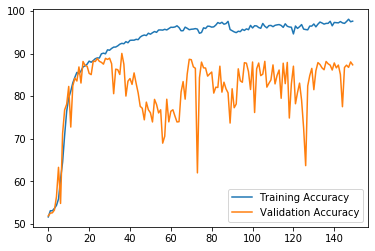

In [0]:
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.legend()
plt.show()

## Load Cornell Data

In [0]:
# main training dataset

cbert_train_url = 'https://raw.githubusercontent.com/lcassels/cbert_aug/develop/datasets/cornell/train.tsv'
cbert_test_url = 'https://raw.githubusercontent.com/lcassels/cbert_aug/develop/datasets/cornell/test.tsv'

cbert_train = pd.read_csv(cbert_train_url, sep='\t')
cbert_test = pd.read_csv(cbert_test_url, sep='\t')

In [0]:
cbert_train, cbert_val = train_test_split(cbert_train, test_size=0.1, random_state=0, shuffle=True)
cbert_train.reset_index(inplace=True)
cbert_train.drop(columns=["index"], inplace=True)
cbert_val.reset_index(inplace=True)
cbert_val.drop(columns=["index"], inplace=True)

In [0]:
cbert_train.head()

,sentence,label
0,"but when those worlds collide , taking the liv...",1
1,"sus problemas empiezan cuando bigardo , un pre...",1
2,"it's unfortunate that wallace , who wrote gibs...",0
3,"dr . david gale , an advocate of eliminating t...",1
4,they're just a couple of cops in copmovieland ...,0


## Train on Cornell dataset

In [0]:
# Parameters
params = {'batch_size': batch_size,
          'shuffle': False,
          'drop_last': True}

training_loader = DataLoader(Intents(cbert_train), **params)
testing_loader = DataLoader(Intents(cbert_test), **params)
val_loader = DataLoader(Intents(cbert_val), **params)

In [0]:
model = LSTMClassifierRoberta(batch_size, output_size, hidden_size)

In [0]:
train_acc_history = []
val_acc_history = []
for epoch in range(150):
    train_loss, train_acc = train_model(model, training_loader, epoch)
    val_loss, val_acc = eval_model(model, val_loader)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.2f}%')

print(f'Best train acc: {max(train_acc_history):.2f}%, best val acc: {max(val_acc_history):.2f}%')

(train_model) Epoch: 1, Idx: 100, Training Loss: 0.6959, Training Accuracy:  50.00%
(train_model) Epoch: 1, Idx: 200, Training Loss: 0.7134, Training Accuracy:  43.75%
(train_model) Epoch: 1, Idx: 300, Training Loss: 0.7343, Training Accuracy:  37.50%
(train_model) Epoch: 1, Idx: 400, Training Loss: 0.6525, Training Accuracy:  62.50%
Epoch: 01, Train Loss: 0.693, Train Acc: 52.17%, Val. Loss: 0.687580, Val. Acc: 52.62%
(train_model) Epoch: 2, Idx: 100, Training Loss: 0.6267, Training Accuracy:  87.50%
(train_model) Epoch: 2, Idx: 200, Training Loss: 0.7234, Training Accuracy:  37.50%
(train_model) Epoch: 2, Idx: 300, Training Loss: 0.7155, Training Accuracy:  37.50%
(train_model) Epoch: 2, Idx: 400, Training Loss: 0.6572, Training Accuracy:  68.75%
Epoch: 02, Train Loss: 0.686, Train Acc: 54.22%, Val. Loss: 0.686959, Val. Acc: 52.66%
(train_model) Epoch: 3, Idx: 100, Training Loss: 0.6568, Training Accuracy:  68.75%
(train_model) Epoch: 3, Idx: 200, Training Loss: 0.6941, Training Accu

(train_model) Epoch: 20, Idx: 200, Training Loss: 0.3428, Training Accuracy:  87.50%
(train_model) Epoch: 20, Idx: 300, Training Loss: 0.2554, Training Accuracy:  93.75%
(train_model) Epoch: 20, Idx: 400, Training Loss: 0.1724, Training Accuracy:  100.00%
Epoch: 20, Train Loss: 0.274, Train Acc: 88.76%, Val. Loss: 0.288090, Val. Acc: 88.74%
(train_model) Epoch: 21, Idx: 100, Training Loss: 0.4875, Training Accuracy:  81.25%
(train_model) Epoch: 21, Idx: 200, Training Loss: 0.4427, Training Accuracy:  87.50%
(train_model) Epoch: 21, Idx: 300, Training Loss: 0.1716, Training Accuracy:  93.75%
(train_model) Epoch: 21, Idx: 400, Training Loss: 0.2678, Training Accuracy:  81.25%
Epoch: 21, Train Loss: 0.269, Train Acc: 88.91%, Val. Loss: 0.297666, Val. Acc: 88.80%
(train_model) Epoch: 22, Idx: 100, Training Loss: 0.3115, Training Accuracy:  87.50%
(train_model) Epoch: 22, Idx: 200, Training Loss: 0.3057, Training Accuracy:  93.75%
(train_model) Epoch: 22, Idx: 300, Training Loss: 0.5228, Tr

(train_model) Epoch: 39, Idx: 200, Training Loss: 0.1323, Training Accuracy:  93.75%
(train_model) Epoch: 39, Idx: 300, Training Loss: 0.0980, Training Accuracy:  93.75%
(train_model) Epoch: 39, Idx: 400, Training Loss: 0.3081, Training Accuracy:  81.25%
Epoch: 39, Train Loss: 0.164, Train Acc: 93.87%, Val. Loss: 0.294791, Val. Acc: 87.36%
(train_model) Epoch: 40, Idx: 100, Training Loss: 0.3362, Training Accuracy:  87.50%
(train_model) Epoch: 40, Idx: 200, Training Loss: 0.1333, Training Accuracy:  93.75%
(train_model) Epoch: 40, Idx: 300, Training Loss: 0.1415, Training Accuracy:  100.00%
(train_model) Epoch: 40, Idx: 400, Training Loss: 0.2213, Training Accuracy:  87.50%
Epoch: 40, Train Loss: 0.163, Train Acc: 93.75%, Val. Loss: 0.303861, Val. Acc: 89.04%
(train_model) Epoch: 41, Idx: 100, Training Loss: 0.6933, Training Accuracy:  50.00%
(train_model) Epoch: 41, Idx: 200, Training Loss: 0.7055, Training Accuracy:  37.50%
(train_model) Epoch: 41, Idx: 300, Training Loss: 0.8298, Tr

(train_model) Epoch: 58, Idx: 200, Training Loss: 0.1083, Training Accuracy:  100.00%
(train_model) Epoch: 58, Idx: 300, Training Loss: 0.4267, Training Accuracy:  87.50%
(train_model) Epoch: 58, Idx: 400, Training Loss: 0.0974, Training Accuracy:  100.00%
Epoch: 58, Train Loss: 0.151, Train Acc: 94.74%, Val. Loss: 0.266154, Val. Acc: 89.18%
(train_model) Epoch: 59, Idx: 100, Training Loss: 0.5972, Training Accuracy:  75.00%
(train_model) Epoch: 59, Idx: 200, Training Loss: 0.1224, Training Accuracy:  93.75%
(train_model) Epoch: 59, Idx: 300, Training Loss: 0.1152, Training Accuracy:  100.00%
(train_model) Epoch: 59, Idx: 400, Training Loss: 0.0567, Training Accuracy:  100.00%
Epoch: 59, Train Loss: 0.142, Train Acc: 94.60%, Val. Loss: 0.436353, Val. Acc: 80.60%
(train_model) Epoch: 60, Idx: 100, Training Loss: 0.2620, Training Accuracy:  87.50%
(train_model) Epoch: 60, Idx: 200, Training Loss: 0.1498, Training Accuracy:  93.75%
(train_model) Epoch: 60, Idx: 300, Training Loss: 0.0401,

(train_model) Epoch: 77, Idx: 200, Training Loss: 0.0196, Training Accuracy:  100.00%
(train_model) Epoch: 77, Idx: 300, Training Loss: 0.0584, Training Accuracy:  93.75%
(train_model) Epoch: 77, Idx: 400, Training Loss: 0.0508, Training Accuracy:  100.00%
Epoch: 77, Train Loss: 0.087, Train Acc: 96.87%, Val. Loss: 0.284407, Val. Acc: 88.24%
(train_model) Epoch: 78, Idx: 100, Training Loss: 0.0279, Training Accuracy:  100.00%
(train_model) Epoch: 78, Idx: 200, Training Loss: 0.0076, Training Accuracy:  100.00%
(train_model) Epoch: 78, Idx: 300, Training Loss: 0.0068, Training Accuracy:  100.00%
(train_model) Epoch: 78, Idx: 400, Training Loss: 0.0139, Training Accuracy:  100.00%
Epoch: 78, Train Loss: 0.080, Train Acc: 97.53%, Val. Loss: 0.346305, Val. Acc: 83.30%
(train_model) Epoch: 79, Idx: 100, Training Loss: 0.0786, Training Accuracy:  100.00%
(train_model) Epoch: 79, Idx: 200, Training Loss: 0.0179, Training Accuracy:  100.00%
(train_model) Epoch: 79, Idx: 300, Training Loss: 0.0

(train_model) Epoch: 96, Idx: 200, Training Loss: 0.0301, Training Accuracy:  100.00%
(train_model) Epoch: 96, Idx: 300, Training Loss: 0.0032, Training Accuracy:  100.00%
(train_model) Epoch: 96, Idx: 400, Training Loss: 0.0104, Training Accuracy:  100.00%


KeyboardInterrupt: 

In [0]:
print(f'Best train acc: {max(train_acc_history):.2f}%, best val acc: {max(val_acc_history):.2f}%')

Best train acc: 97.87%, best val acc: 90.70%


In [0]:
# test_loss, test_acc = eval_model(model, test_iter)
# print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}%')


In [0]:
# ''' Let us now predict on a single sentence just for the testing purpose. '''
# test_sen1 = "This is one of the best creation of Nolan. I can say, it's his magnum opus. Loved the soundtrack and especially those creative dialogues."
# test_sen2 = "Ohh, such a ridiculous movie. Not gonna recommend it to anyone. Complete waste of time and money."

# # format sentence into a 1 x max_seq_len tokenized and padded np array, then convert to tensor
# # test_sen1 = ...

# test_sen = np.asarray(test_sen1)
# test_sen = torch.LongTensor(test_sen)

# test_tensor = Variable(test_sen, volatile=True)
# test_tensor = test_tensor.cuda()

# model.eval()
# output = model(test_tensor, 1)
# print(output)
# out = F.softmax(output, 1)
# print(out)

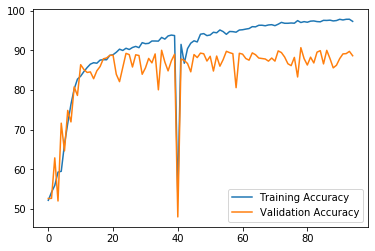

In [0]:
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.legend()
plt.show()